In [12]:
import netCDF4 as nc
import math
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [13]:
h = nc.Dataset('Data/S5P_OFFL_L1C_SIFTRS_20240206T123417_20240206T123957_32732_93_010100_20250228T104502_irr.nc')
africa = h.groups['africa']
h1 = nc.Dataset('Data/S5P_OFFL_L1C_SIFTRS_20240206T105346_20240206T105827_32731_93_010100_20250228T104244_irr.nc')
africa1 = h1.groups['africa']

In [14]:
# Remove all scanlines where there is one groundpixel that has a cloud in that combination/coordinate
def filter_scanlines(dataset, cloud_fraction_threshold, reflectance_err_threshold, sza_threshold, vza_threshold,  surface_classification=None):
    scanlines = []
    for n in range(dataset.variables['CloudFraction'].shape[1]):  # Iterate over scanlines
        if (dataset.variables['CloudFraction'][0, n, 223] < cloud_fraction_threshold).all() and \
           (dataset.variables["Reflectance_err"][0, n, 223] < reflectance_err_threshold).all() and \
           (dataset.variables["SZA"][0, n, 223] < sza_threshold).all() and \
           (dataset.variables["VZA"][0, n, 223] < vza_threshold).all() and \
           (dataset.variables["SurfaceClassification"][0, n, 223] == surface_classification).all():
            scanlines.append(n)
    return scanlines

scanline_nocloud = filter_scanlines(africa, cloud_fraction_threshold=0.4, reflectance_err_threshold=80, sza_threshold=75, vza_threshold=65, surface_classification=148)
scanline_nocloud1 = filter_scanlines(africa1, cloud_fraction_threshold=0.4, reflectance_err_threshold=80, sza_threshold=75, vza_threshold=65, surface_classification=148)

nocloud_value = np.concatenate((scanline_nocloud, scanline_nocloud1), axis=0)
nocloud_value.shape

(570,)

In [15]:
#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
        
ds = nc.Dataset("Data/wl_per_grpx_sahara_b.nc")
wl_per_gp_sahara_b = ds.variables["Ref_wl"][:]
wl_ground_pixel_224 = wl_per_gp_sahara_b[223, :]  # select ground pixel 224 (index 223)
wl = wl_ground_pixel_224 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 5 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, :, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((len(scanline_nocloud), len(ind)))
for idx, i in enumerate(scanline_nocloud):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo[idx, :] = surf_alb

ref_na1 = africa1.variables["Reflectance"][0, :, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo1 = np.zeros((len(scanline_nocloud1), len(ind)))
for idx, i in enumerate(scanline_nocloud1):
    poly_sa = po.polyfit (wl[ind_na], ref_na1[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo1[idx, :] = surf_alb

albedo_value = np.concatenate((surf_albedo, surf_albedo1), axis = 0)

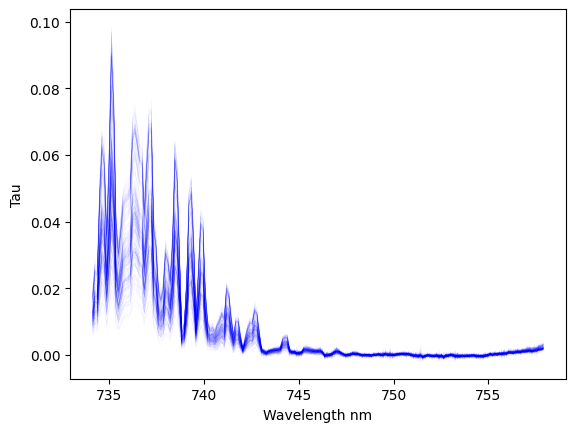

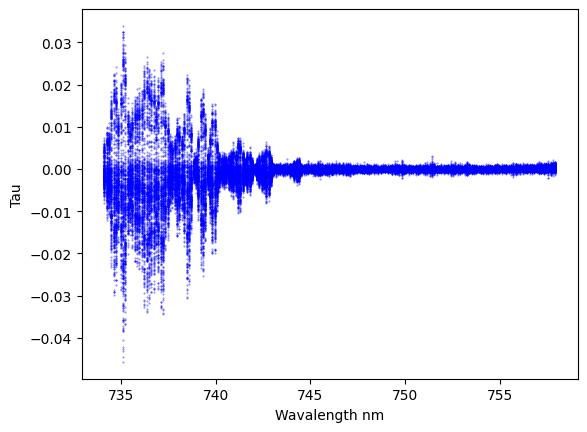

Centered data shape: (570, 194)
Mean after centering: 6.766030231213399e-17


In [16]:
#Computing tau
mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,223]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,223]))
mu_matrix = np.tile(mu[:, np.newaxis], len(ind))
mu_0_matrix = np.tile(mu_0[:, np.newaxis], len(ind))
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 223, ind].data


mu1 = np.cos(np.radians(africa1.variables["VZA"][0,scanline_nocloud1,223]))
mu_01 = np.cos(np.radians(africa1.variables["SZA"][0,scanline_nocloud1,223]))
mu_matrix1 = np.tile(mu1[:, np.newaxis], len(ind))
mu_0_matrix1 = np.tile(mu_01[:, np.newaxis], len(ind))
reflectance_matrix1 = africa1.variables['Reflectance'][0, scanline_nocloud1, 223, ind].data

mu_value =np.concatenate((mu_matrix, mu_matrix1), axis = 0)
mu_0_value = np.concatenate((mu_0_matrix, mu_0_matrix1), axis = 0)
reflectance_value = np.concatenate((reflectance_matrix, reflectance_matrix1), axis = 0)
angle_value = (mu_value + mu_0_value)/mu_value*mu_0_value
tau_value = -np.log(reflectance_value/albedo_value)/angle_value


for idx, i  in enumerate(scanline_nocloud):
    plt.plot(wl[ind], tau_value[idx],color='blue', alpha=0.1, linewidth=0.1)
    plt.xlabel("Wavelength nm")
    plt.ylabel("Tau")
plt.show()

# Center data
mean_spectrum = np.mean(tau_value, axis=0)
tau_centered = tau_value - mean_spectrum
for idx, i  in enumerate(scanline_nocloud):
    plt.scatter(wl[ind], tau_centered[idx],color='blue', alpha = 0.5, s= 0.2)
    plt.xlabel('Wavalength nm')
    plt.ylabel('Tau')
    #what is the unit?? 
plt.show()

# Verify
print("Centered data shape:", tau_centered.shape)
print("Mean after centering:", np.mean(tau_centered, axis=0).max())  # Should be ~0

In [17]:
# # transminatance = reflectance_value/albedo_value
# #I want a plot a 406 by 448 of SIF values 
# correct_scanline_nocloud = []
# for m in range(448):
#     for n in range(406):
#         if (africa.variables['CloudFraction'][0,n,m]<0.4).all():
#                 if (africa.variables["Reflectance_err"][0,n,m]<80).all():
#                     if (africa.variables["SZA"][0,n,m]<75).all():
#                         scanline_nocloud.append(n)

# albedo_matrix = []
# for m in range(448):
#     ds = nc.Dataset("Data/wl_per_grpx_sahara_b.nc")
#     wl_per_gp_sahara_b = ds.variables["Ref_wl"][:]
#     wl_ground_pixel_224 = wl_per_gp_sahara_b[m, :]  # select ground pixel 224 (index 223:224)
#     wl = wl_ground_pixel_224 
#     retrievalWindow = (734, 758) # retrieval wavelength window [nm]
#     windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
#     sb_order = 2 # order of polynomial fit of surface reflectivity (barren)
#     ind    = indexate(wl, retrievalWindow)
#     ind_na = indexate(wl, windowsOfNoAbsorption)
#     ref_na = africa.variables["Reflectance"][0, :, m, ind_na].data.tolist()
    
#     #for each scanline model the albedo with the noabsobtion window of reflectance
#     surf_albedo = np.zeros((len(scanline_nocloud), 194))
#     for idx, i in enumerate(scanline_nocloud):
#         poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
#         surf_alb = po.polyval (wl[ind], poly_sa)
#         surf_albedo[idx, :] = surf_alb

#     albedo_matrix.append(surf_albedo)

# mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,223]))
# mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,223]))
# mu_matrix = np.tile(mu[:, np.newaxis], 194)
# mu_0_matrix = np.tile(mu_0[:, np.newaxis], 194)
# reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 223, ind].data
# tau_value =  -np.log(reflectance_matrix/surf_albedo)/((mu_matrix + mu_0_matrix)/mu_matrix*mu_0_matrix)


# # transmitance_matrix = reflectance_matrix/surf_albedo
# # up_transmitance_matrix = np.exp(-tau*(np.reciprocal(mu_matrix)/(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))))
# # irradiance_matrix = np.tile(irradiance_value.T, (406, 1))
# # # #this multiplication is not precisely reflect because of really small computer error as in they are not exact values 
# # diff = reflectance_matrix - surf_albedo*transmitance_matrix
# # I = irradiance_matrix*mu_0_matrix*(np.round(diff, decimals=12))/(up_transmitance_matrix*math.pi) #this I is really I/E_0 
# # # plt.plot(wl[ind],I.mean(axis=0))
# # # plt.xlabel('Wavelength')
# # # plt.ylabel("$I_{SIF}/E_0$")
# # # #plt.savefig("SIF")
# # # plt.show()

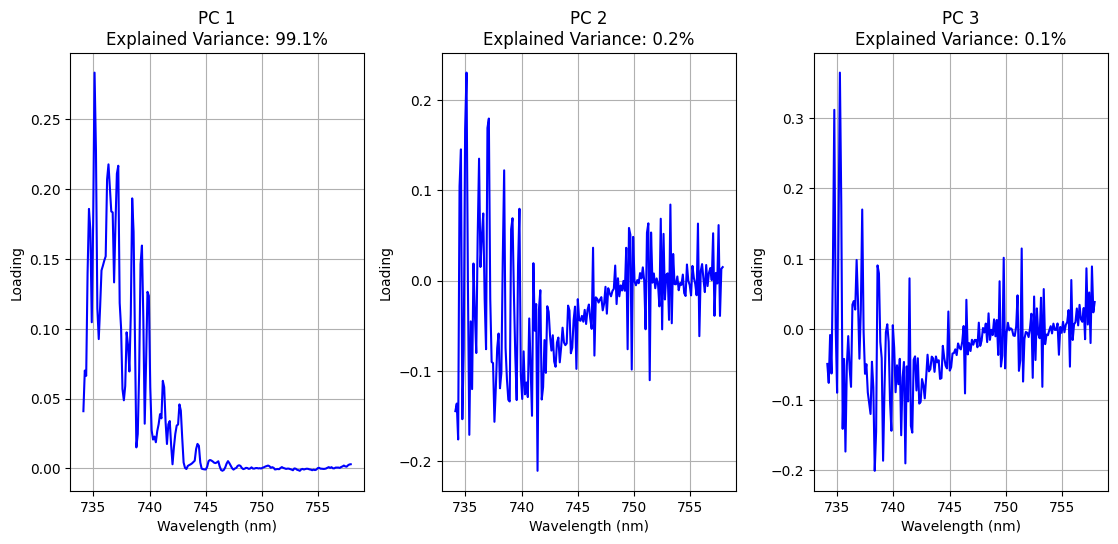

Explained variance by 10 PCs: 99.78%


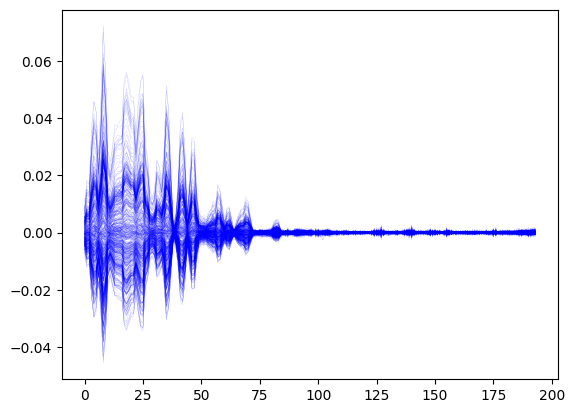

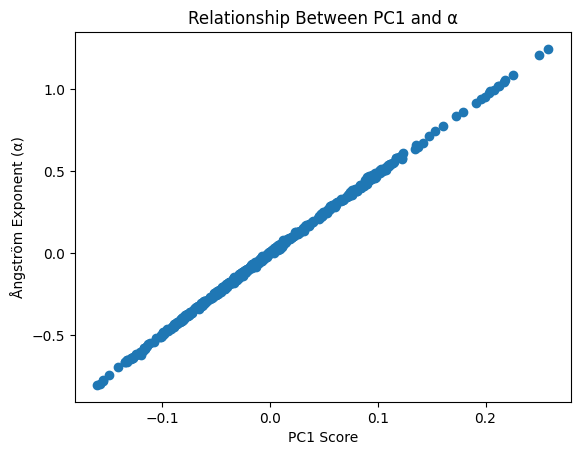

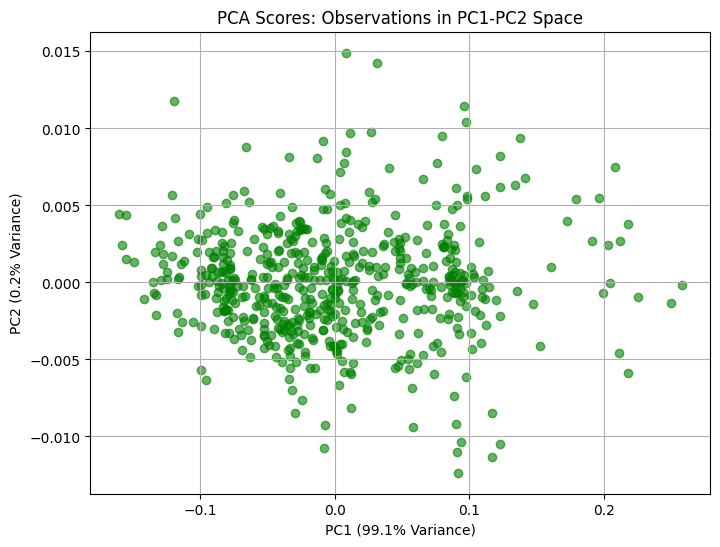

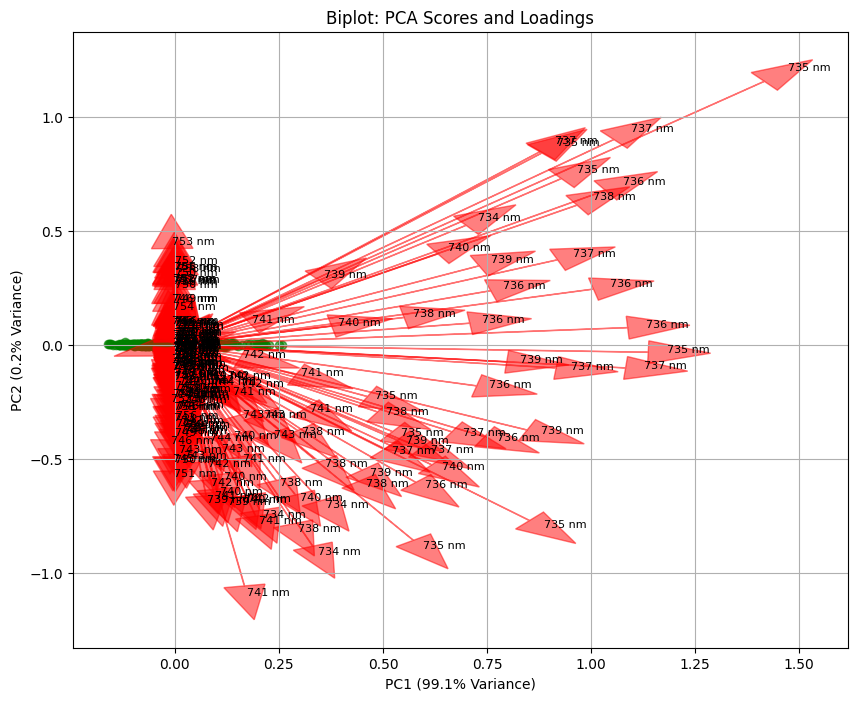

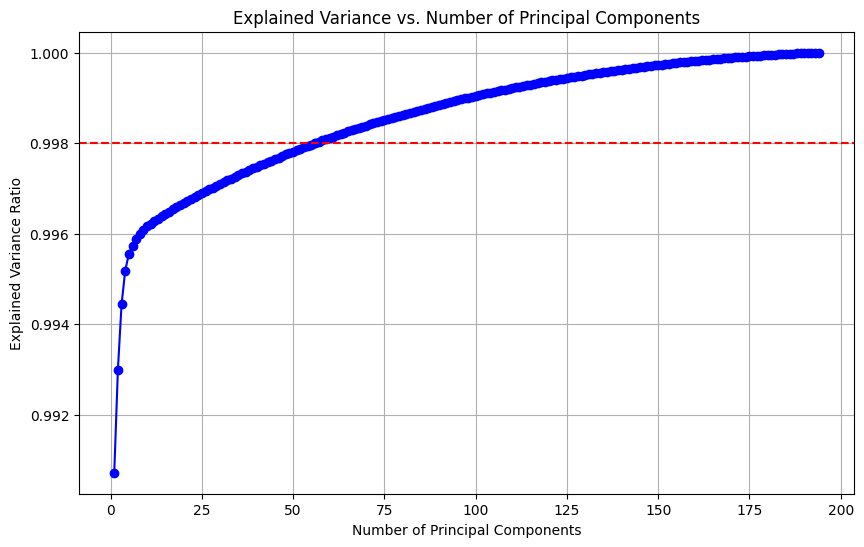

In [30]:
from sklearn.decomposition import PCA
from scipy.stats import linregress
pca = PCA(n_components=50).fit(tau_centered)
components = pca.components_

plt.figure(figsize=(15, 20))
for i in range(3):
    plt.subplot(4, 4, i+1)  # 4x4 grid
    plt.plot(wl[ind], components[i], color='blue')
    plt.title(f'PC {i+1}\nExplained Variance: {pca.explained_variance_ratio_[i]*100:.1f}%')
    plt.xlabel("Feature Index" if wl[ind] is None else "Wavelength (nm)")
    plt.ylabel("Loading")
    plt.grid(True)
plt.tight_layout()
plt.savefig("PCA_tau")
plt.show()

print(f"Explained variance by 10 PCs: {np.sum(pca.explained_variance_ratio_):.2%}")

tau_pca = pca.transform(tau_centered)  # Shape: (317, 10)
tau_reconstructed = pca.inverse_transform(tau_pca)  # Shape: (317, 195)
plt.plot(tau_reconstructed.T,color='blue', alpha = 0.5, linewidth = 0.1)
plt.show()

# Use PC1 scores (most dominant component) as a predictor
pc1_scores = tau_pca[:, 0]

# Fit τ = β ⋅ λ^(-α) using PC1 as a proxy for wavelength dependence
log_w = np.log(wl[ind])
log_tau = np.log(tau_centered + 1)  # Avoid log(0)

# Fit regression for each observation (317 total)
alpha_values = []
beta_values = []
for i in range(tau_value.shape[0]):
    slope, intercept, _, _, _ = linregress(log_w, log_tau[i])
    alpha_values.append(-slope)
    beta_values.append(np.exp(intercept))

# Compare α with PC1 scores (dominant variability)
plt.scatter(pc1_scores, alpha_values)
plt.xlabel('PC1 Score')
plt.ylabel('Ångström Exponent (α)')
plt.title('Relationship Between PC1 and α')
plt.show()

# Project data to PCA space
tau_pca = pca.transform(tau_centered)  # Shape: (317, 10)

# Scatter plot of scores for PC1 vs. PC2
plt.figure(figsize=(8, 6))
plt.scatter(tau_pca[:, 0], tau_pca[:, 1], alpha=0.6, c='green')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} Variance)')
plt.title('PCA Scores: Observations in PC1-PC2 Space')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(tau_pca[:, 0], tau_pca[:, 1], alpha=0.6, c='green', label='Observations')

# Plot eigenvectors as arrows
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, x*5, y*5, color='red', alpha=0.5, head_width=0.1)
    plt.text(x*5.2, y*5.2, f'{wl[ind][i]:.0f} nm', color='black', fontsize=8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} Variance)')
plt.title('Biplot: PCA Scores and Loadings')
plt.grid(True)
plt.show()
# Calculate explained variance for all possible n_components
explained_variance_ratios = []
n_components_range = range(1, tau_centered.shape[1] + 1)  # From 1 to the number of features

for n in n_components_range:
    pca_temp = PCA(n_components=n).fit(tau_centered)
    explained_variance_ratios.append(np.sum(pca_temp.explained_variance_ratio_))

# Plot explained variance vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, explained_variance_ratios, marker='o', linestyle='-', color='blue')

# Add a horizontal threshold line at 0.998
plt.axhline(y=0.998, color='red', linestyle='--', label='Threshold (0.998)')

# Find the number of components that meet the threshold
threshold_index = next((i for i, evr in enumerate(explained_variance_ratios) if evr >= 0.998), None)
if threshold_index is not None:
    plt.scatter(threshold_index + 1, explained_variance_ratios[threshold_index], color='green', label=f'{threshold_index + 1} Components')

plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()


In [19]:
##SIF-retrieval 

In [20]:
#SOLAR IRRADIANCE -- The same in all areas of the world 
irradiance_vector = africa.variables["irradiance"][223, ind]
#CONVERTING UNITS --- Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹
def convert_irradiance(irradiance_mol, wavelength_nm):
    """
    Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ (photon flux) to mW m⁻² nm⁻¹.

    Parameters:
        irradiance_mol (array-like): Irradiance in mol s⁻¹ m⁻² nm⁻¹
        wavelength_nm (array-like): Corresponding wavelengths in nm

    Returns:
        array: Irradiance in mW m⁻² nm⁻¹
    """
    # Constants
    h = 6.62607015e-34  # Planck constant (J·s)
    c = 2.99792458e8    # Speed of light (m/s)
    Na = 6.02214076e23  # Avogadro's number (photons/mol)

    wavelength_m = np.array(wavelength_nm) * 1e-9  # Convert nm to m
    photon_energy = h * c / wavelength_m           # Energy per photon (J)

    irradiance_watts = np.array(irradiance_mol) * Na * photon_energy  # W m⁻² nm⁻¹
    irradiance_mW = irradiance_watts * 1e3  # Convert W to mW

    return irradiance_mW
       
irradiance_value = convert_irradiance(irradiance_vector, wl[ind])

(50, 194)
Fitted parameters:
[ 8.21439482e+03 -3.27812876e+01  4.35896519e-02 -1.93139317e-05
  8.83815843e-01 -1.14578624e+00  8.28162321e-01 -2.30949645e-01
 -8.10886365e-01  8.77156118e-01 -2.08544692e-01 -2.15337301e-01
  7.00382490e-01 -5.35062347e-01 -2.29663949e-01  7.31092246e-01
 -9.09551785e-02 -1.55428895e+00 -4.27481059e-01  3.62975912e-01
 -2.59786070e-01  3.24522673e-01  9.15974984e-01 -3.77956132e-01
 -3.07933807e-01 -3.31890291e-01  3.07770163e-01  8.12547955e-01
 -4.41265494e-01  5.46890619e-01  3.33968927e-01 -5.70078603e-01
 -6.49361457e-01 -1.58146098e-02 -7.07925911e-01 -2.52732160e-01
  9.02715319e-03  2.97466966e-01 -2.89473597e-02 -2.05325766e-01
 -5.45676870e-01  1.10537003e+00 -3.69278769e-01  3.11420323e-01
  5.15778832e-01 -8.88124494e-01  2.21025443e-01  1.95478231e-01
 -6.51572261e-01 -1.93779120e-01  2.13712730e-01  2.46323178e-03
  5.85476737e-01  2.59834342e-01  3.36760403e+02]


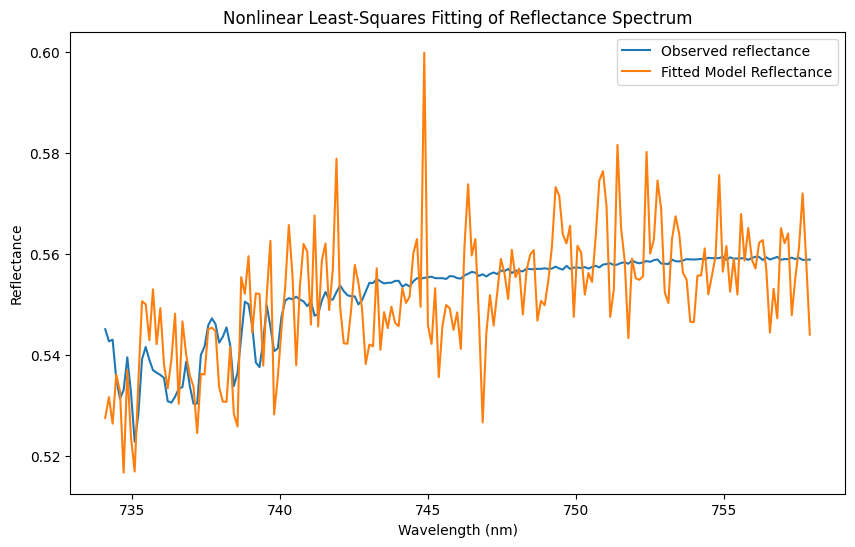

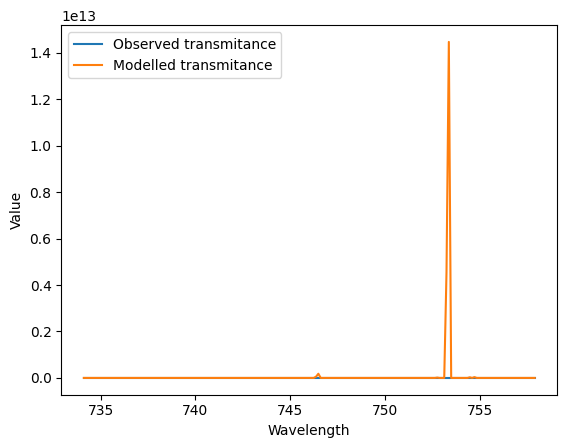

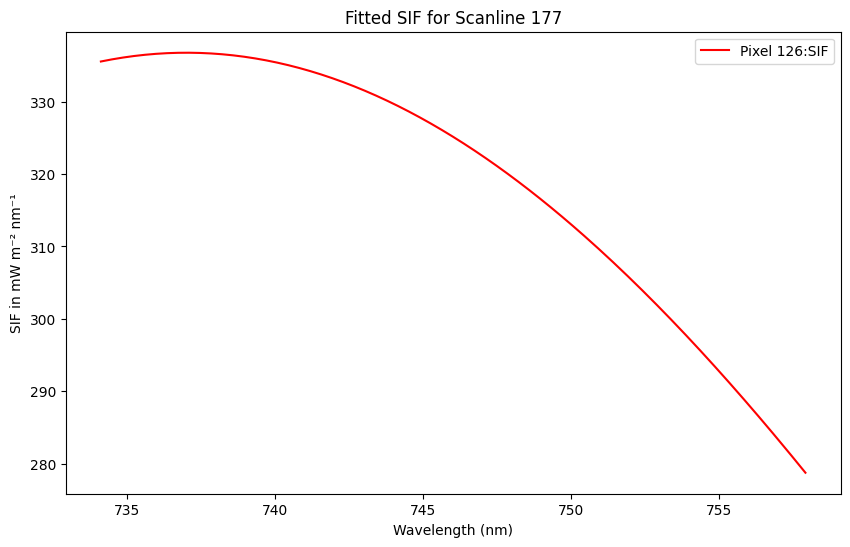

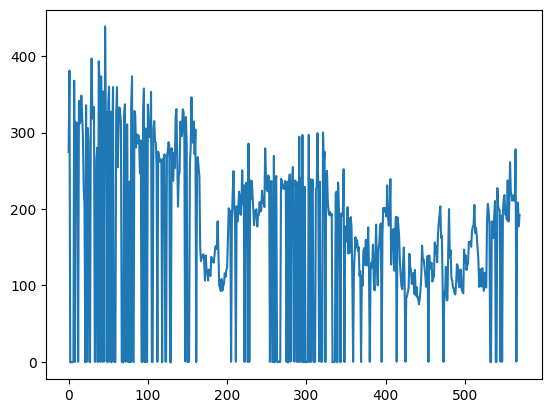

In [22]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
m = 4
SIF_values_per_scanline = []
for pixel_index, i in enumerate(nocloud_value):
    reflectance_observed = reflectance_value[pixel_index]
    def reflectance_model(lam, *params):

        # Unpack parameters
        a = np.array(params[0:m]) 
        b = np.array(params[m:n+m])
        c = params[n+m]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        poly_term = sum(a[j] * lam**j for j in range(m))
        baseline = poly_term * np.exp(-attenuation)
    
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_value[pixel_index]) / ((1 / mu_value[pixel_index]) + (1 / mu_0_value[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_value[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5]*m + [0.5] * n + [0.5]

    # lower_bounds = [-np.inf] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
    # upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds),maxfev=10000)

    SIF_values_per_scanline.append(popt[-1])

    if pixel_index == 100:
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        #plt.savefig("LM-fitting_mean")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_value) + np.reciprocal(mu_0_value))*tau_value)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_value[100]) + np.reciprocal(mu_0_value[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("ML_fit_mean_tropomi")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud[100]}:SIF", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("SIF in mW m⁻² nm⁻¹")
        plt.title("Fitted SIF for Scanline 177")
        plt.legend()
        #plt.savefig("ML_fit_mean_SIF")
        plt.show()
plt.plot(SIF_values_per_scanline)
plt.show() 

In [23]:
np.mean(SIF_values_per_scanline)

np.float64(162.6131614533895)

(50, 194)
Fitted parameters:
[ 2.02335316e-01 -6.97927413e-03 -2.55359472e-03  1.07241259e-02
 -4.93561030e-03  1.11494281e-03  4.45524046e-04  8.28786045e-04
 -9.67093070e-05  1.21617184e-03  7.77008297e-04 -3.65977988e-04
  1.10081791e-04  6.96848476e-04  7.00521073e-04 -5.35447274e-04
 -1.75194405e-04  2.30274124e-05  4.68052850e-04 -2.08588016e-04
 -2.27703547e-04 -4.15881227e-04  1.52800882e-04 -3.43772211e-04
  7.88108255e-04  3.19509069e-04 -1.26057871e-05  4.44498605e-04
  2.79927187e-04 -4.50141239e-04 -1.47133519e-04  4.66686188e-04
  8.84662121e-04 -5.66513879e-04 -1.94488164e-04 -6.47127667e-05
  6.50857089e-04  1.01152874e-04 -9.01264336e-04  1.69644930e-04
 -1.47504885e-04 -4.00235088e-05  4.54285961e-04 -3.44341894e-04
  3.18368815e-04  2.21658186e-04  6.31362128e-04  2.89630323e-04
 -2.16553090e-05 -3.94056165e-04 -1.50275213e-03]


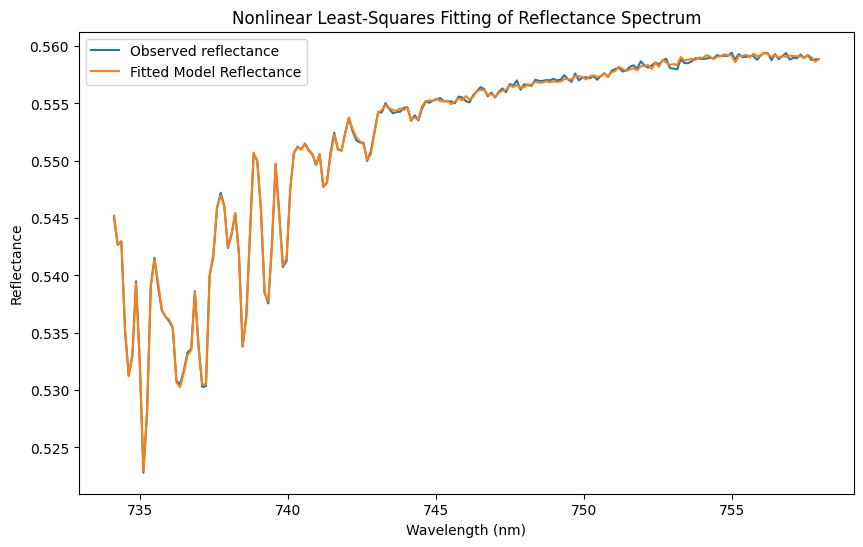

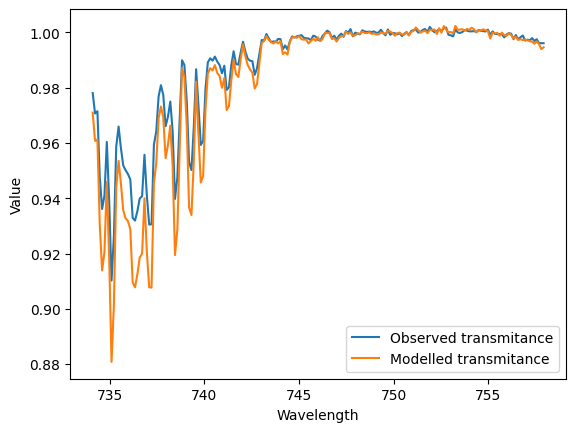

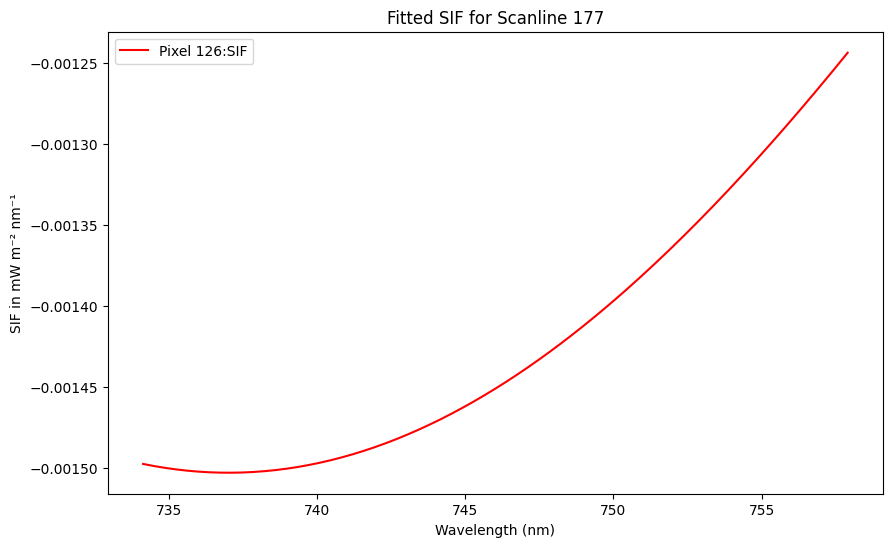

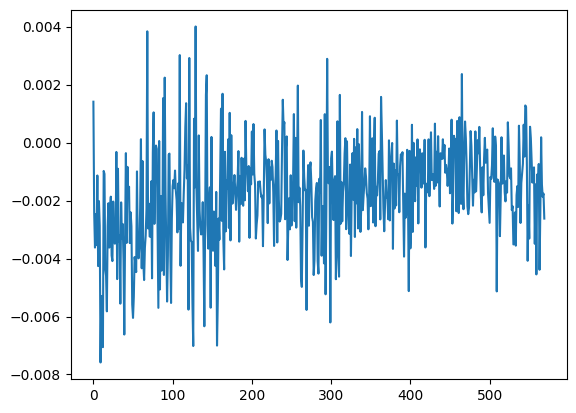

In [24]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
SIF_values_per_scanline = []
for pixel_index, i in enumerate(nocloud_value):
    reflectance_observed = reflectance_value[pixel_index]
    def reflectance_model(lam, *params):
    
        # Unpack parameters
        b = np.array(params[0:n])
        c = params[n]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        # Baseline reflectance term:
        baseline = albedo_value[pixel_index] * np.exp(-attenuation)
        
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_value[pixel_index]) / ((1 / mu_value[pixel_index]) + (1 / mu_0_value[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_value[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5] * n + [0.5]
    # lower_bounds = [-np.inf] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
    # upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds),maxfev=10000)

    SIF_values_per_scanline.append(popt[-1])
    if pixel_index == 100:
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        #plt.savefig("LM-fitting_mean")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_value) + np.reciprocal(mu_0_value))*tau_value)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_value[100]) + np.reciprocal(mu_0_value[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("ML_fit_mean_tropomi")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud[100]}:SIF", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("SIF in mW m⁻² nm⁻¹")
        plt.title("Fitted SIF for Scanline 177")
        plt.legend()
        #plt.savefig("ML_fit_mean_SIF")
        plt.show()

plt.plot(SIF_values_per_scanline)
plt.show()  

In [25]:
h2 = nc.Dataset('Data/S5P_OFFL_L1C_SIFTRS_20240206T172817_20240206T173755_32735_93_010100_20250228T104827_irr.nc')
amazon = h2.groups['amazon']

In [26]:
#Remove clouds
scanline_nocloud2 = []
for n in range(406):
    if (amazon.variables['CloudFraction'][0,n,223]<0.4).all():
            if (amazon.variables["Reflectance_err"][0,n,223]<80).all():
                if (amazon.variables["SZA"][0,n,223]<75).all():
                    scanline_nocloud2.append(n)
sc_nc2 = len(scanline_nocloud2)
#Fixing albedo 

ref_na2 = amazon.variables["Reflectance"][0, scanline_nocloud2, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_alb2 = np.zeros((sc_nc2, 194))
for i in range(sc_nc2):
    poly_sa = po.polyfit (wl[ind_na], ref_na2[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_alb2[i, :] = surf_alb

#Computing tau
mu2 = np.cos(np.radians(amazon.variables["VZA"][0,scanline_nocloud2,223]))
mu_02 = np.cos(np.radians(amazon.variables["SZA"][0,scanline_nocloud2,223]))
mu_matrix2 = np.tile(mu2[:, np.newaxis], (1,194))
mu_0_matrix2 = np.tile(mu_02[:, np.newaxis],(1, 194))
reflectance_matrix2 = amazon.variables['Reflectance'][0, scanline_nocloud2, 223, ind]


tau2 = -np.log(reflectance_matrix2/surf_alb2)/ (np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))

tau_mean2 = tau2.mean(axis = 0)

(50, 194)
Fitted parameters:
[-1.88784927e+01  5.03936815e-02 -3.31434999e-05  8.55603288e-01
 -1.00035629e-02 -2.07493369e-02 -3.14576248e-02  7.37982812e-03
  1.71253864e-03  4.01406987e-03  1.33370285e-02 -9.52607448e-03
 -2.44007169e-03 -2.20903299e-04 -1.43591420e-03  2.39345464e-03
  7.99612393e-04 -1.77404786e-04 -1.11974925e-03  1.29831230e-03
 -1.35798202e-03  1.66369680e-03  2.36786519e-03 -8.87490114e-04
  3.41285464e-04  1.47614422e-03  3.61452179e-04 -1.31358290e-04
  1.00956427e-03 -1.57344185e-03  1.40553958e-03  3.30237493e-04
 -1.37784756e-03 -7.75656578e-04  1.30079404e-03  1.72225309e-03
 -4.59907477e-04  2.14054680e-03  1.10948682e-04  5.98495683e-04
  1.01164400e-03 -1.01677674e-03  2.15252806e-03  3.52841488e-04
 -9.11190033e-05 -8.79172077e-04 -1.22447909e-03  1.60236976e-03
  9.35395086e-05  7.98712609e-05 -8.72840127e-04 -1.71871287e-04
  2.00924551e-04  2.55580654e+00]


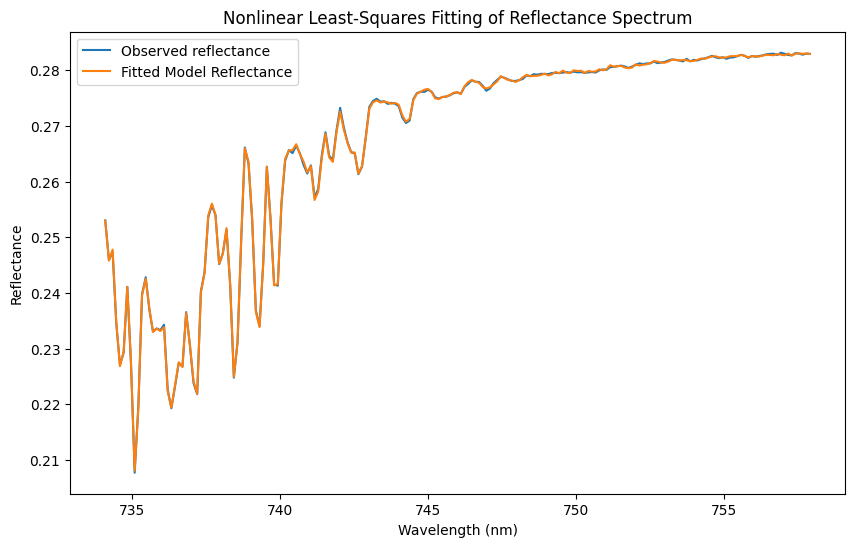

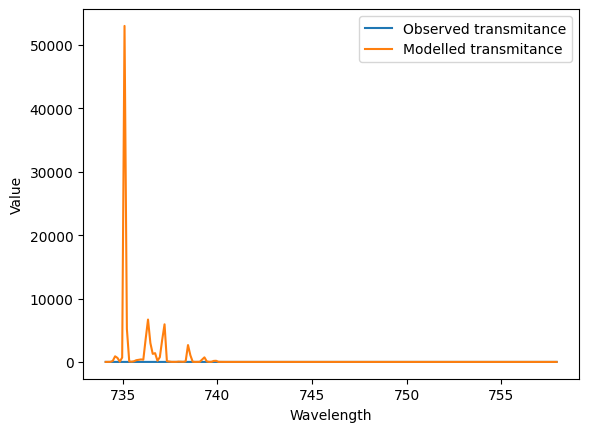

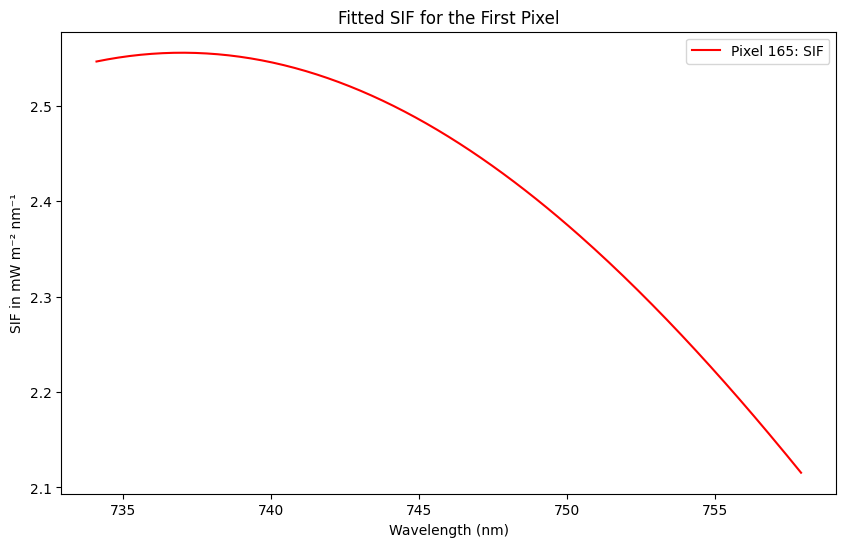

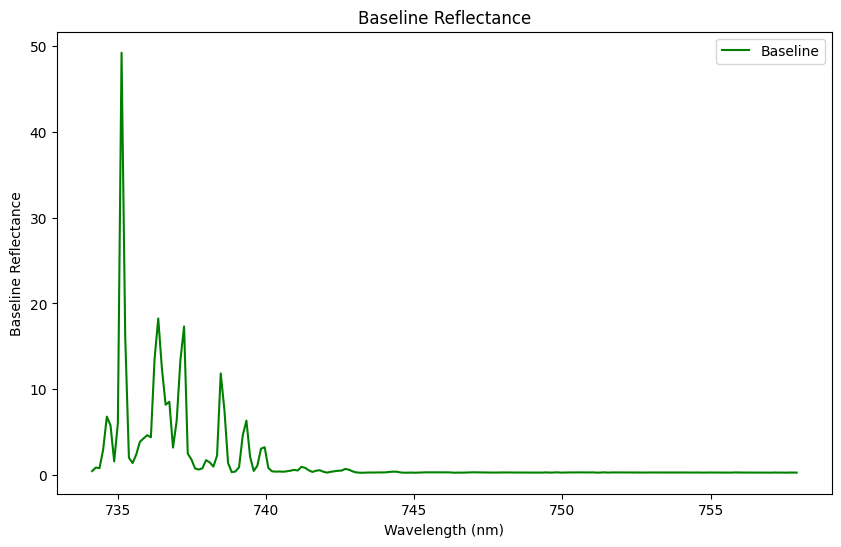

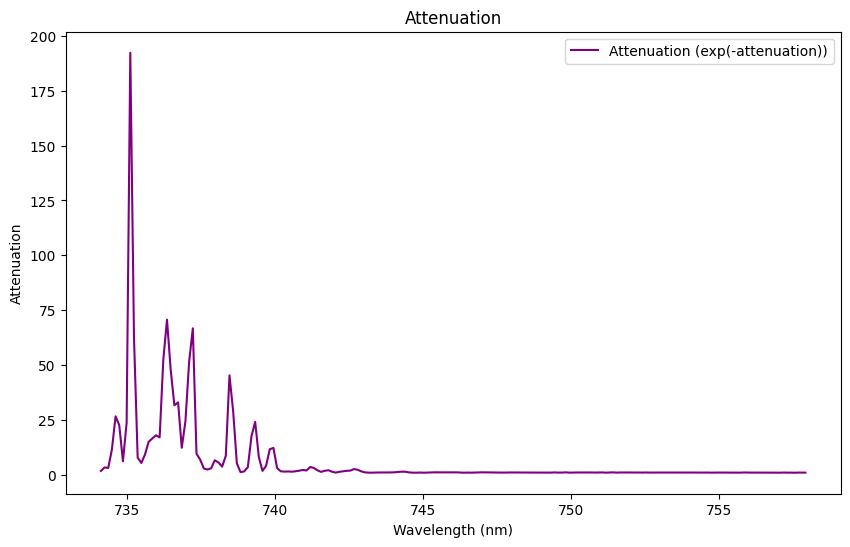

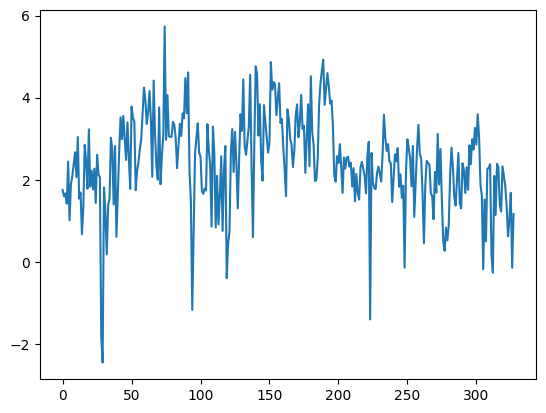

2.418372007107816


In [32]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
SIF_values_per_scanline_m_A = []
for pixel_index, i in enumerate(scanline_nocloud2):
    reflectance_observed = amazon.variables['Reflectance'][0, i, 223,ind].data
    m = 3
    def reflectance_model(lam, *params):

        # Unpack parameters
        a = np.array(params[0:m]) 
        b = np.array(params[m:n+m])
        c = params[n+m]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        poly_term = sum(a[j] * lam**j for j in range(m))
        baseline = poly_term * np.exp(-attenuation)
    
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5]*m + [0.5] * n + [0.5]

    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)

    SIF_values_per_scanline_m_A.append(popt[-1])
    if pixel_index == 100:
        popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)
        
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        #plt.savefig("LM-fitting_mean_A")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2))*tau2)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("LM_fit_mean_A")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[100]}: SIF", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("SIF in mW m⁻² nm⁻¹")
        plt.title("Fitted SIF for the First Pixel")
        plt.legend()
        #plt.savefig("LM_fit_SIF_mean_A")
        plt.show()

        # Compute the baseline and attenuation for plotting
        baseline_fit = sum(popt[j] * wl[ind]**j for j in range(m)) * np.exp(-attenuation_fit)
        attenuation_fit_exp = np.exp(-attenuation_fit)

        # Plot the baseline
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], baseline_fit, label="Baseline", color='green')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Baseline Reflectance")
        plt.title("Baseline Reflectance")
        plt.legend()
        plt.show()

        # Plot the attenuation
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], attenuation_fit_exp, label="Attenuation (exp(-attenuation))", color='purple')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Attenuation")
        plt.title("Attenuation")
        plt.legend()
        plt.show()


plt.plot(SIF_values_per_scanline_m_A)
plt.show()
print(np.mean(SIF_values_per_scanline_m_A))

Fitted parameters:
[-3.56386542e+01  9.45165613e-02 -6.19702711e-05  5.97633170e-01
 -3.54463140e-02 -4.87589582e-02 -2.11984148e-02  4.41753208e-03
  1.03753208e-02  4.10884836e-03  1.52440187e-02 -4.42084439e-03
  3.45954305e-04  1.00440809e-03 -2.33039612e-03 -8.05444164e-04
  3.33320794e-03  2.13333527e-04 -1.34438959e-04  9.83160159e-04
 -1.86761049e-03 -5.39942725e-04  2.03377238e-03 -1.05471264e-03
 -9.21826881e-04  1.17358853e-03 -1.98238912e-03 -3.60793847e-04
  9.30565753e-04 -1.51609635e-03  1.04604924e-03 -6.81807341e-04
 -7.45619594e-04 -1.94710161e-03 -7.62222369e-04  1.71457549e-03
  9.82327079e-04  9.62943547e-04  1.06390482e-03  4.99748110e-04
  6.49217070e-04 -2.19781586e-04  2.10209507e-03 -4.94809810e-04
  7.90022902e-04 -9.56426206e-04 -7.12204441e-04  2.03653956e-03
  1.24385169e-04 -1.12077653e-03 -1.90199784e-04 -1.53120179e-04
  1.99962352e-04  1.16334358e+00]


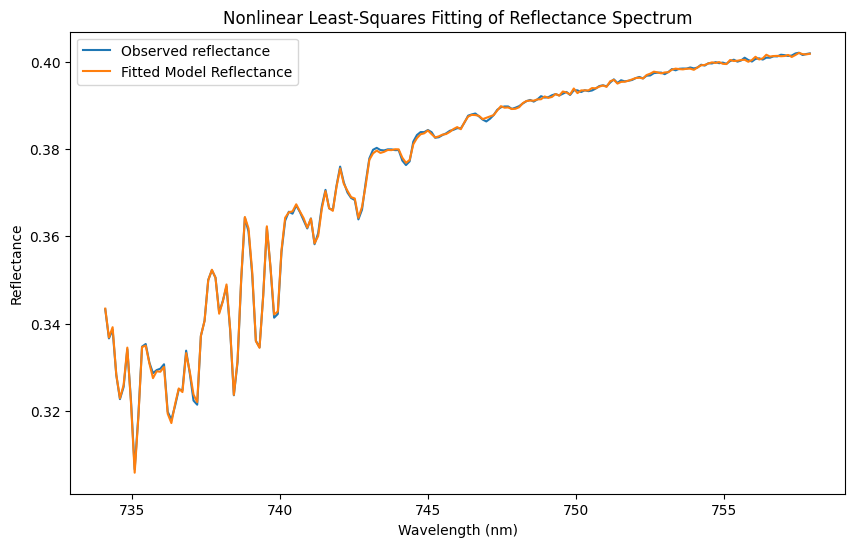

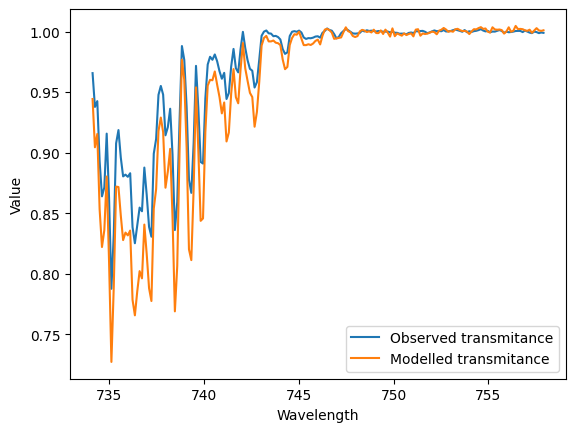

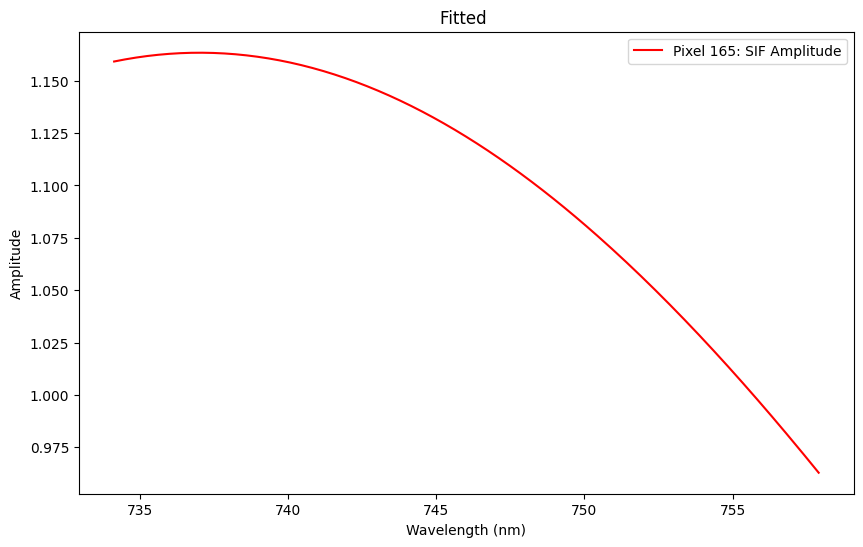

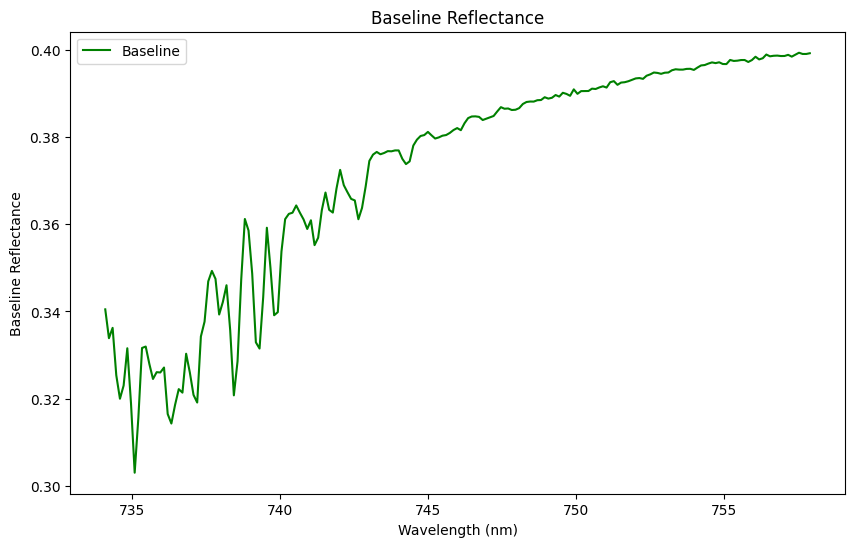

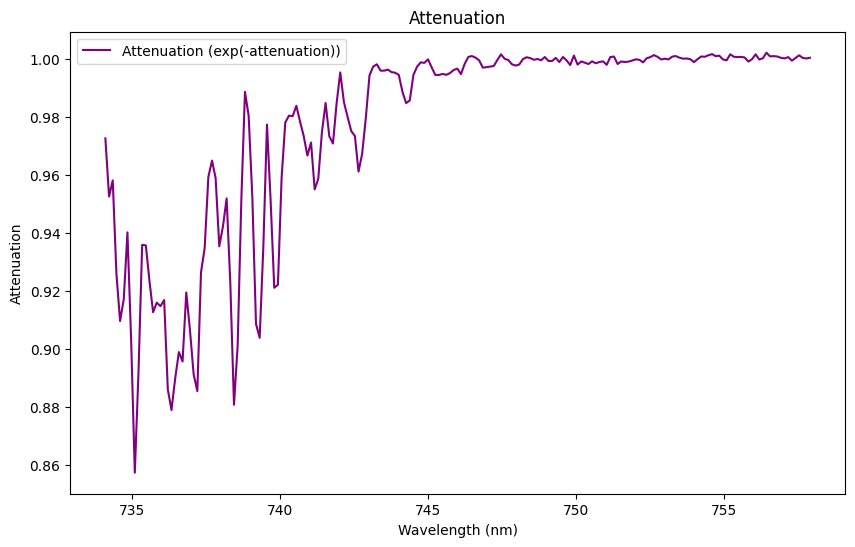

In [33]:
m = 3
def reflectance_model(lam, *params):

    # Unpack parameters
    a = np.array(params[0:m]) 
    b = np.array(params[m:n+m])
    c = params[n+m]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    poly_term = sum(a[j] * lam**j for j in range(m))
    baseline = poly_term * np.exp(-attenuation)

    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5]*m + [0.5] * n + [1]
# lower_bounds = [-np.inf] * (n+m) + [0]  # Allow b parameters to be anything, but c must be ≥ 0
# upper_bounds = [np.inf] * (n+m) + [np.inf]

popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds))

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
#plt.savefig("LM-fitting_AE_A")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*tau2[100])
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[m:n+m])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
#plt.savefig("LM_fit_AE_transmitance_A")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[100]}: SIF Amplitude", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted ")
plt.legend()
#plt.savefig("LM_fit_SIF_AE_A")
plt.show()

# Compute the baseline and attenuation for plotting
baseline_fit = sum(popt[j] * wl[ind]**j for j in range(m)) * np.exp(-attenuation_fit)
attenuation_fit_exp = np.exp(-attenuation_fit)

# Plot the baseline
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], baseline_fit, label="Baseline", color='green')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Baseline Reflectance")
plt.title("Baseline Reflectance")
plt.legend()
plt.show()

# Plot the attenuation
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], attenuation_fit_exp, label="Attenuation (exp(-attenuation))", color='purple')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Attenuation")
plt.title("Attenuation")
plt.legend()
plt.show()

(50, 194)
Fitted parameters:
[ 8.66961722e-01 -1.96391352e-02 -2.63672418e-02 -2.32886632e-02
  5.38744363e-03  1.33432748e-03  3.52584991e-03  1.62571803e-02
 -4.92984009e-03 -3.01893723e-03 -6.54333693e-04 -4.96893617e-04
  1.14443942e-03  6.19236770e-04  6.48738720e-05 -9.81154891e-04
 -1.15969769e-03 -1.27668468e-03  1.68252774e-03  1.52821670e-03
 -1.34839291e-03  2.17717849e-04 -1.31947874e-03  2.69783495e-05
 -4.92030173e-04  1.55618813e-04 -1.42423830e-03 -1.03294221e-03
  1.96560205e-03  4.78512135e-04  2.22234690e-04  1.04027383e-03
 -2.06897137e-05 -1.54300477e-03  2.21014628e-03  8.38228275e-04
 -1.41349177e-03  1.61442806e-04  1.39544726e-03  1.71491029e-04
  8.32526063e-04  1.81195557e-03 -2.32818152e-03 -1.25158958e-03
  3.52295142e-04  3.22464521e-04  9.33313461e-05  6.22032053e-04
  5.68442129e-04  1.15093951e-03 -7.89498812e-04]


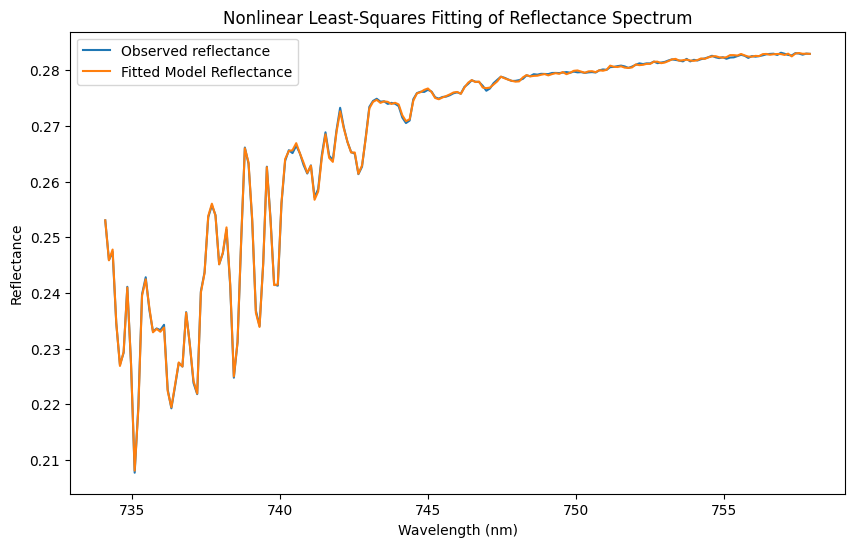

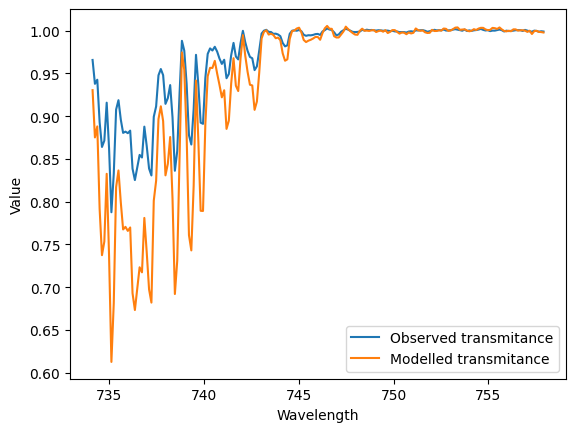

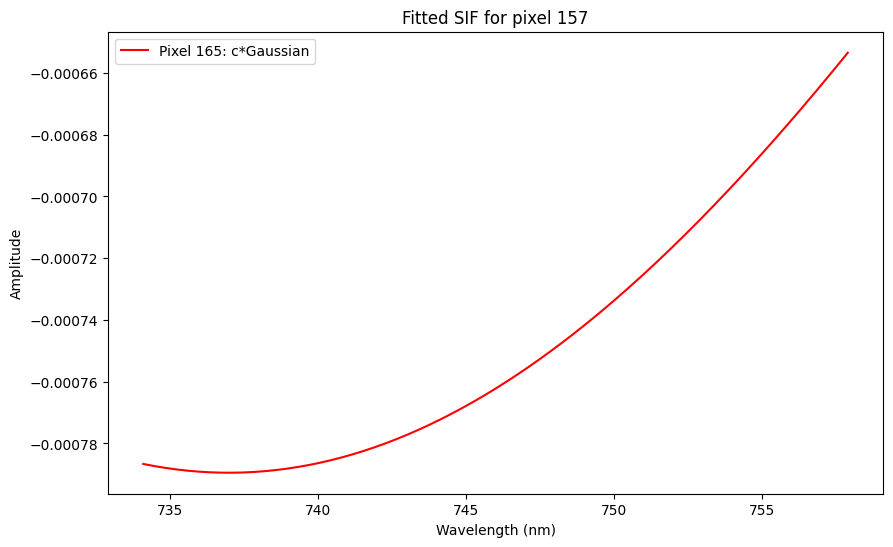

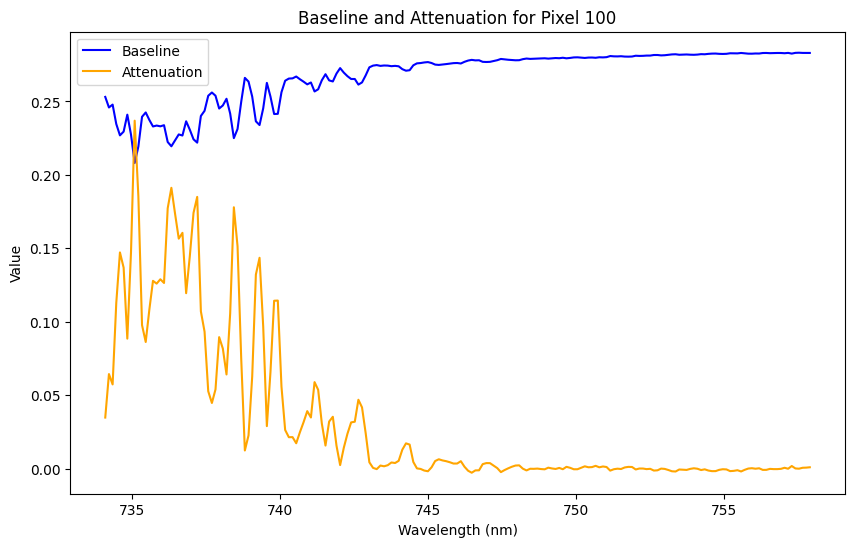

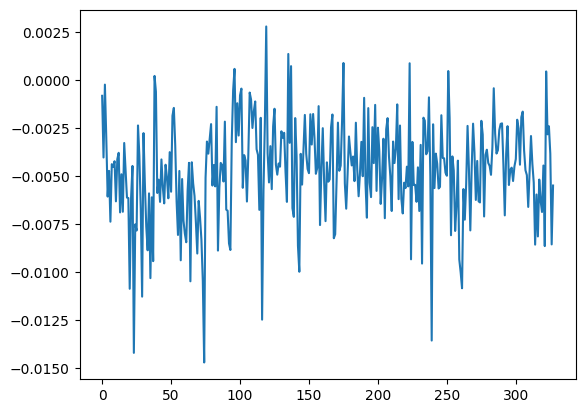

-0.004722893382132726


In [28]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
pixel_index = 100
SIF_values_per_scanline_A = []
for pixel_index, i in enumerate(scanline_nocloud2):
    reflectance_observed = amazon.variables['Reflectance'][0, i, 223,ind].data
    def reflectance_model(lam, *params):
    
        # Unpack parameters
        
        b = np.array(params[0:n])
        c = params[n]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        # Baseline reflectance term:
        baseline = surf_alb2[pixel_index] * np.exp(-attenuation)
        
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0] * n + [0]
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)
    SIF_values_per_scanline_A.append(popt[-1])
    
    if pixel_index == 100:
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        #plt.savefig("LM-fitting_AE_A")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2))*tau2)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("LM_fit_AE_transmitance_A")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[100]}: c*Gaussian", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Amplitude")
        plt.title("Fitted SIF for pixel 157")
        #plt.savefig("LM_fit_SIF_AE_A")
        plt.legend()
        plt.show()

        # Compute baseline and attenuation for the pixel at index 100
        b_fit = np.array(popt[0:n])
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

        baseline_fit = surf_alb2[100] * np.exp(-attenuation_fit)

        # Plot baseline and attenuation
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], baseline_fit, label="Baseline", color='blue')
        plt.plot(wl[ind], attenuation_fit, label="Attenuation", color='orange')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Value")
        plt.title("Baseline and Attenuation for Pixel 100")
        plt.legend()
        plt.show()
plt.plot(SIF_values_per_scanline_A)
plt.show()
print(np.mean(SIF_values_per_scanline_A))        


In [29]:
#np.savez("sif_values_pca.npz", m_alb=SIF_values_per_scanline_m_A, alb = SIF_values_per_scanline_A)